# Exercises

The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
2. Forecast, plot and evaluate using each at least 4 of the methods we discussed:
* Last Observed Value
* Simple Average
* Moving Average
* Holt's Linear Trend
* Holt's Seasonal Trend
* Based on previous year/month/etc., this is up to you.

* Bonus: 
1. Using the store item demand data, create a forecast of sales_total and quantity for 2018 using the Previous Cycle approach. .
2. Predict 2018 total monthly sales for a single store and/or item by creating a model using prophet. 
3. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper). 
4. Plot the 2018 monthly sales predictions.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import acquire
import prepare
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 


In [2]:
df = acquire.wrangle_store_data()

In [3]:
df = prepare.prepare_store_data(df)

In [4]:
df.isna().sum()

store_id         0
item_id          0
item_upc14       0
item_upc12       0
item_brand       0
item_name        0
item_price       0
sale_id          0
quantity         0
store_address    0
store_zipcode    0
store_city       0
store_state      0
month            0
day_of_week      0
sales_total      0
dtype: int64

We will resample to daily aggregating our values using sum. The original granularity is daily, but there are multiple records of the same days across multiple stores.

In [5]:
df_resampled = df.resample('d')[['quantity','sales_total']].sum()

# Drop February 29th from our dataset (a leap year date)
df_resampled = df_resampled[df_resampled.index != '2016-02-29']

df_resampled.head()


,quantity,sales_total
sale_date,,
2013-01-01,411.0,2263.66
2013-01-02,442.0,2376.53
2013-01-03,422.0,2371.98
2013-01-04,473.0,2533.38
2013-01-05,511.0,2827.43


Split

1. We will use the training proportion method to split.
2. Identify the total length of the dataframe and multiple by train_prop to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data. (x = train_prop * 100)
3. Select row indices from 0 up to the index representing x-percentile for train, and from the index representing x-percentile through the end of the dataframe for test. In both of these, we will reset the index in order to return dataframes sorted by datetime.
4. Return train and test dataframes.

In [6]:
train_size = int(len(df_resampled) * .5)
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]


Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test.

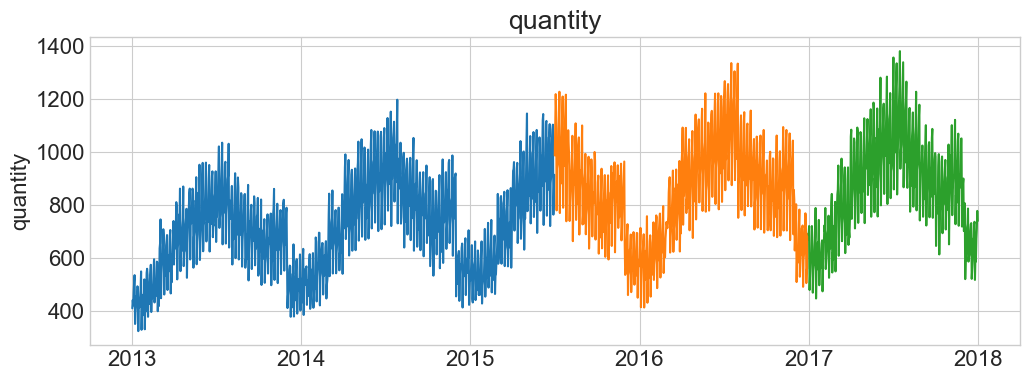

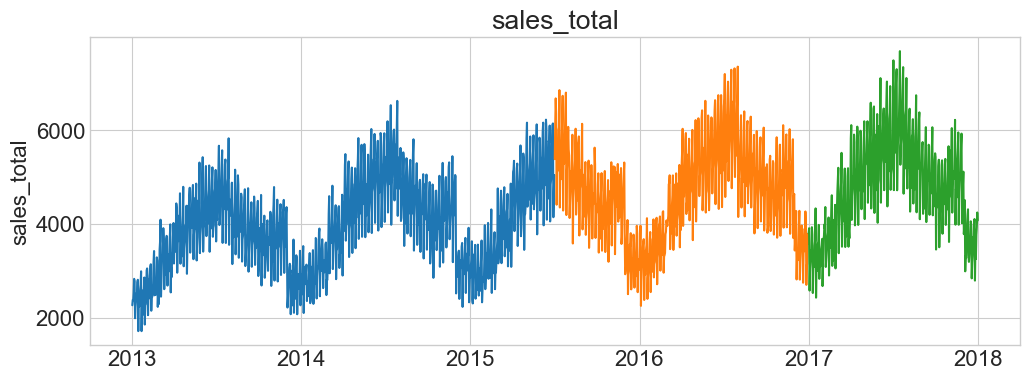

In [7]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


# Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the methods that follow.

evaluate() will compute the Mean Squared Error and the Root Mean Squared Error to evaluate.

In [8]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


plot_and_eval() will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance to make comparisons.

In [9]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


We are planning on evaluating a lot of models. Let's create an easy to read dataframe called eval_df. We will eventually add the metrics we calculate for each of our models to this dataframe for easy comparison.

In [10]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


While we could manually append the performance results of each model to this dataframe, its better to create a function that will do it for us.

append_eval_df() will append evaluation metrics for each model into our eval_df data frame object. This function is dependent on eval_df already existing, which we accomplished in our previous step.

In [11]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


# Forecast

Forecasting is another word for predicting time series data. As a reminder, we will work with the following approaches:

**Baseline Models**

* Last Observed Value
* Simple Average
* Moving Average
* Non-Baseline Models

**Previous Cycle**
* Holt's Linear Trend
* Holt's Seasonal Trend
* Last Observed Value

The simplest method for forecasting is to predict all future values to be the last observed value.

In [12]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]

# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]

yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,5043.81,914.0
2015-07-03,5043.81,914.0
2015-07-04,5043.81,914.0
2015-07-05,5043.81,914.0
2015-07-06,5043.81,914.0


You can see, when peeking into yhat_df, that every predicted value is the same.

**Plot Actual vs. Predicted Values**

Now, let's plot actual and predicted values using our plot_and_eval() function:

quantity -- RMSE: 195


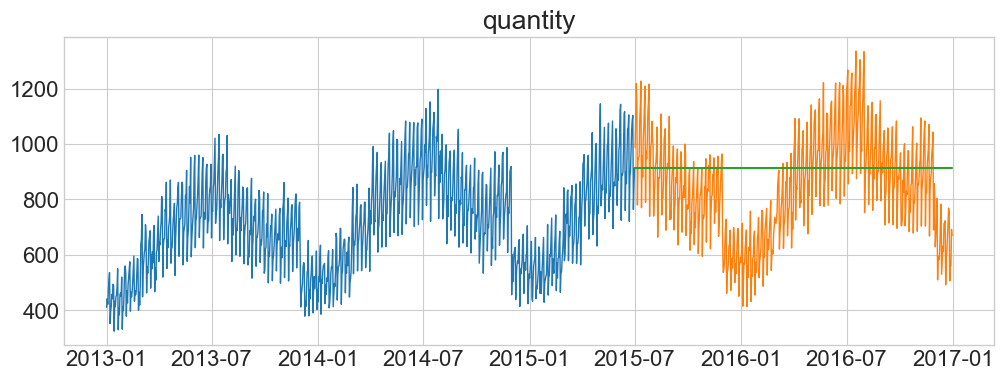

sales_total -- RMSE: 1085


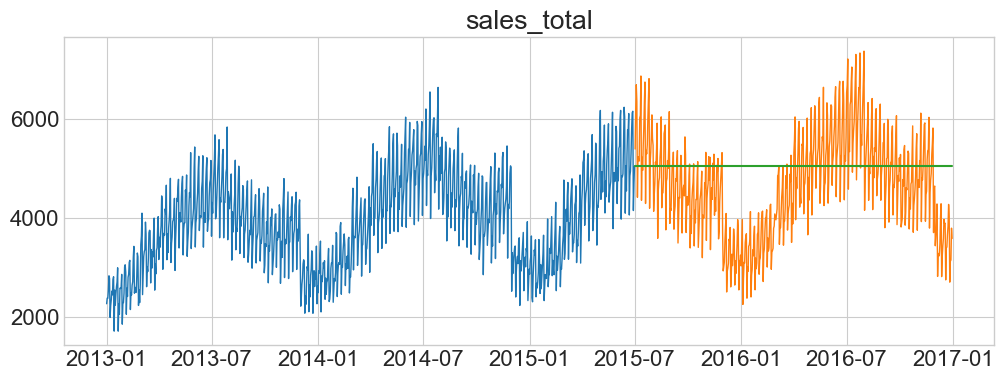

In [13]:
for col in train.columns:
    plot_and_eval(col)


# Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df. We will add our metrics via our append_eval_df() function.

In [14]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


In [15]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,195.0
1,last_observed_value,sales_total,1085.0


# Simple Average

Take the simple average of historical values and use that value to predict future values.

This is a good option for an initial baseline. Every future datapoint (those in 'test') will be assigned the same value, and that value will be the overall mean of the values in train.

In [16]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)

# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)


yhat_df = pd.DataFrame({'sales_total': [avg_sales],
                        'quantity': [avg_quantity]},
                        index=validate.index)

yhat_df.head(3)


,sales_total,quantity
sale_date,,
2015-07-02,3949.46,716.64
2015-07-03,3949.46,716.64
2015-07-04,3949.46,716.64


**Plot Actual vs. Predicted Values**

Similar to our handling of the previous baseline model, we can plot our yhat_df values against the actual values in validate. Our plot_and_eval function accomplishes this.

quantity -- RMSE: 224


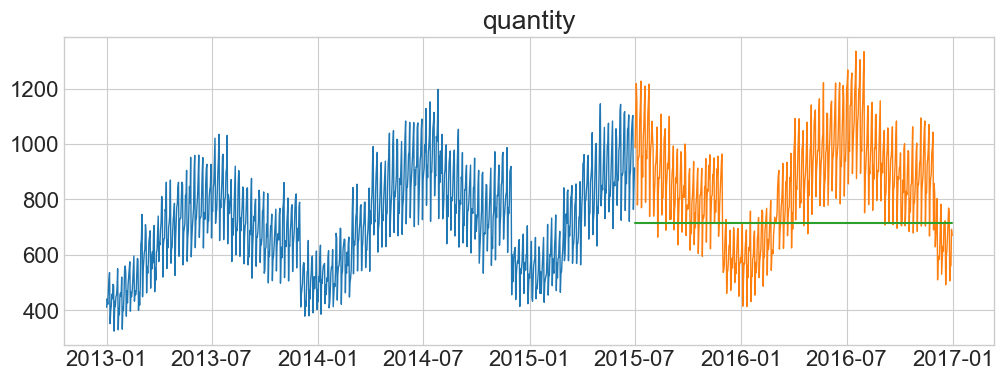

sales_total -- RMSE: 1240


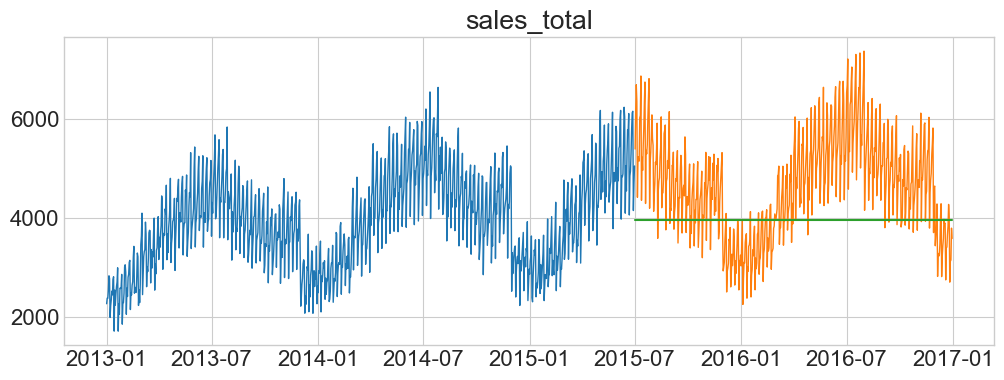

In [17]:
for col in train.columns:
    plot_and_eval(col)


# Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [18]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,195.0
1,last_observed_value,sales_total,1085.0
2,simple_average,quantity,224.0
3,simple_average,sales_total,1240.0


# Moving Average

* In this example, we will use a 30-day moving average to forecast. In other words, the average of the last period, here 30-days, will be used as the forecasted value.

* Moving averages are moving and change over time, but only historically. Forecasts using the moving average use the average of the last period/window of time.

# Make Predictions

There are several ways to obtain the mean of the last 30 periods in train. We will use the .rolling() method to accomplish this.




In [19]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['quantity'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                        'quantity': rolling_quantity},
                         index=validate.index)
yhat_df.head()


,sales_total,quantity
sale_date,,
2015-07-02,5221.92,951.23
2015-07-03,5221.92,951.23
2015-07-04,5221.92,951.23
2015-07-05,5221.92,951.23
2015-07-06,5221.92,951.23


**Plot Actual vs. Predicted Values**

Now, let's plot and evaluate the performance of our time series model using Moving Average

quantity -- RMSE: 211


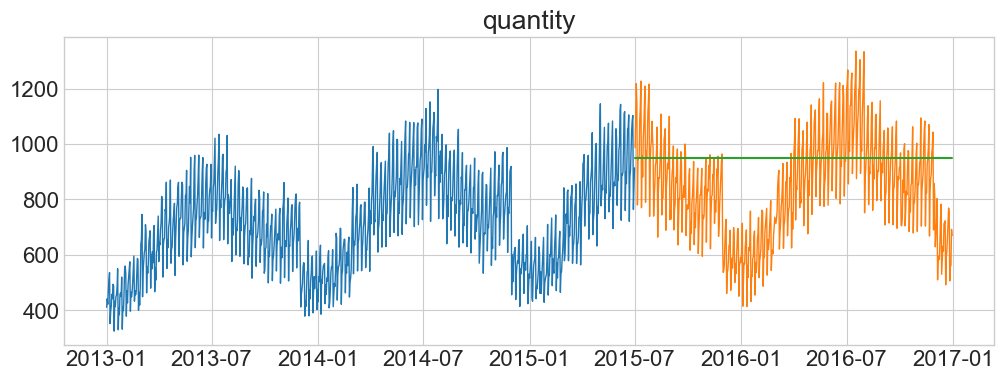

sales_total -- RMSE: 1160


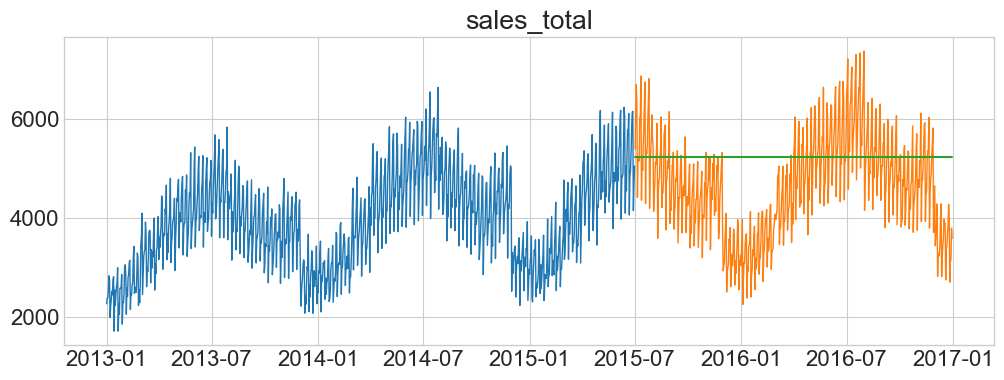

In [20]:
for col in train.columns:
    plot_and_eval(col)


# Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to eval_df

In [21]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,195.0
1,last_observed_value,sales_total,1085.0
2,simple_average,quantity,224.0
3,simple_average,sales_total,1240.0
4,30d moving average,quantity,211.0
5,30d moving average,sales_total,1160.0


In [22]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'sales_total': rolling_sales,
                            'quantity': rolling_quantity},
                            index=validate.index)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)


Let's try out several other values for periods:

In [23]:
eval_df


,model_type,target_var,rmse
0,last_observed_value,quantity,195.0
1,last_observed_value,sales_total,1085.0
2,simple_average,quantity,224.0
3,simple_average,sales_total,1240.0
4,30d moving average,quantity,211.0
5,30d moving average,sales_total,1160.0
6,4_day_moving_avg,quantity,193.0
7,4_day_moving_avg,sales_total,1073.0
8,12_day_moving_avg,quantity,210.0
9,12_day_moving_avg,sales_total,1170.0


Which is best so far?

In [24]:
# get the min rmse for each variable

min_rmse_sales_total = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_quantity = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_sales_total) | 
         (eval_df.rmse == min_rmse_quantity)
        )]


,model_type,target_var,rmse
14,104_day_moving_avg,quantity,185.0
15,104_day_moving_avg,sales_total,1028.0


As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.

# Non-Baseline Models

Two of the models that we will evaluate are based on Holt-Winters, which models on three elements: - A typical value (average) - A slope (trend) over time - And a cyclical repeating pattern (seasonality)

Its worth looking at a seasonal decomposition plot of our target, to inspect these components:



* Seasonal Decomposition

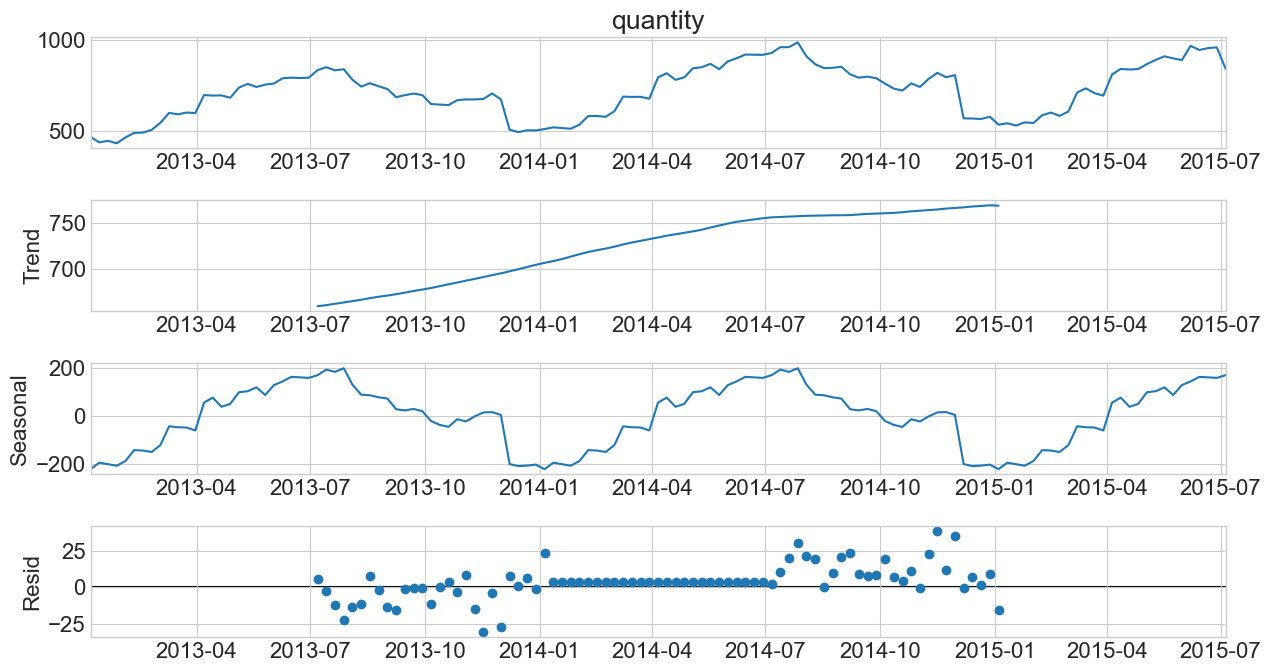

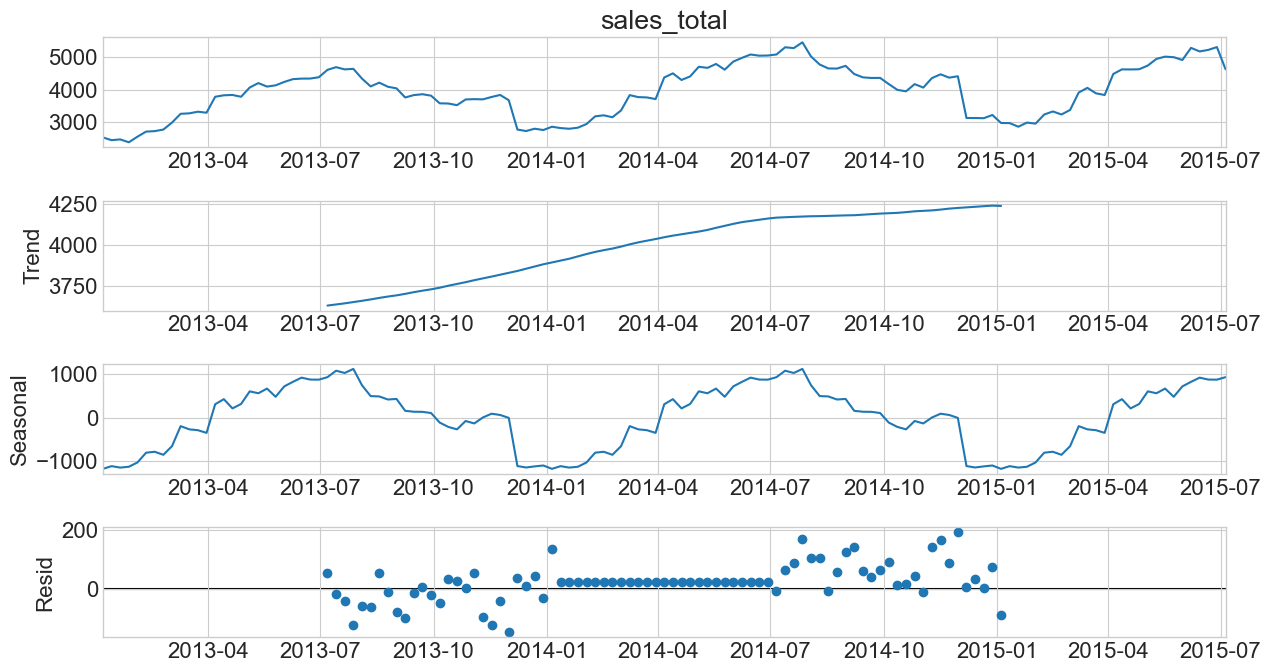

In [25]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()


It looks like there is both strong seasonality and a notable trend in both targets (sales_total and quantity). There are two Holt-Winters models that we will attempt - Holt's Linear Trend - Holt's Seasonal Model

Holt's Linear Trend

Our approach will be similar to many other modeling processes we have performed: 1. Create the object: Holt() 2. Fit the object: .fit() 3. Make predictions: .predict()

The first set of hyperparameters are set when we call Holt():

**exponential** = True/False (exponential vs. linear growth, additive vs. multiplicative)
**damped** ϕ = True/False
with Holt, forecasts tend to increase or decrease indefinitely into the future. To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1.
A second set of hyperparameters are set when we call .fit():

**smoothing_level** (α): value between (0,1)
Closer to 0, the level doesn't change with each new observation
Closer to 1, the level reacts strongly with each new observation

**smoothing_slope** (β): value between (0,1)
Closer to 0, trend is not changing over time
Closer to 1, trend is changing significantly over time

**optimized**: use the auto-optimization that allow statsmodels to automatically find an optimized value for us.

# Make Predictions

Now, like we would when using sklearn, we will create the Holt object, fit the model, and make predictions.

In [26]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [27]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-02,5240.13,949.31
2015-07-03,5241.63,948.61
2015-07-04,5243.11,947.92
2015-07-05,5244.58,947.24
2015-07-06,5246.04,946.57


**Plot Actual vs. Predicted Values**

quantity -- RMSE: 188


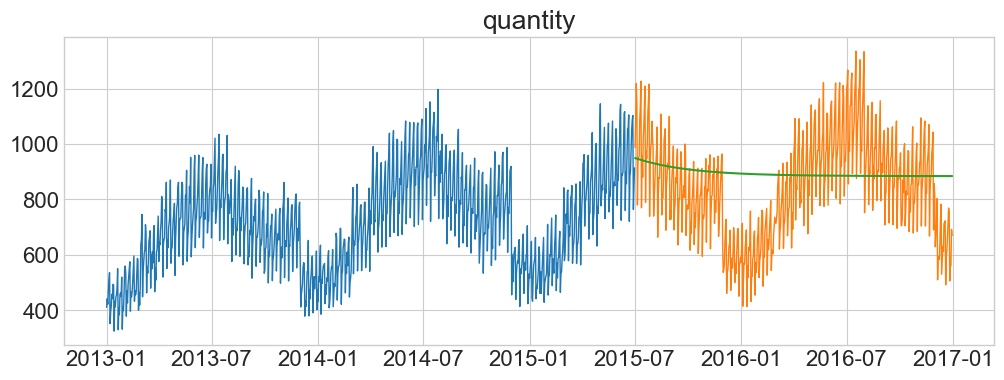

sales_total -- RMSE: 1237


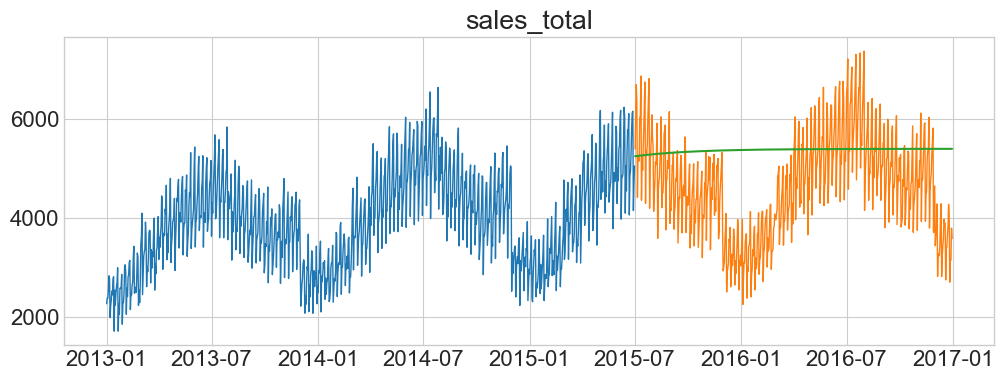

In [28]:
for col in train.columns:
    plot_and_eval(target_var = col)


# Evaluate

In [29]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)


In [30]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,185.0
16,holts_optimized,quantity,188.0
6,4_day_moving_avg,quantity,193.0
0,last_observed_value,quantity,195.0
12,52_day_moving_avg,quantity,200.0
8,12_day_moving_avg,quantity,210.0
4,30d moving average,quantity,211.0
10,26_day_moving_avg,quantity,212.0
2,simple_average,quantity,224.0
15,104_day_moving_avg,sales_total,1028.0


Holt's Seasonal Trend

Holt's Seasonal Trend is started by using ExponentialSmoothing()

The process is similar to our previous model: 1. Create the object: ExponentialSmoothing() 2. Fit the object: .fit() 3. Make predictions: .forecast()

This function has several hyperparameters: - 
**seasonal_periods**: The number of periods representing one cycle of seasonality. This is why performing a decomposition plot can be valuable, as this number needs to be entered manually. - 
**trend**: Whether the overall trend is additive (trend='add') or multiplicative (trend='mul') - 
**seasonal**: Whether the seasonality is additive (seasonal='add') or multiplicative (seasonal='mul') - **damped**: If we want the trend to reduce over the length of the forecast to avoid absurd long term predictions, we can set damped=True

Given our smaller dataset, rather than choosing any one combination of hyperparameters, we can create multiple models to test different combinations:

In [31]:
# Models for quantity
hst_quantity_fit1 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_quantity_fit2 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_quantity_fit3 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_quantity_fit4 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

# Models for sales
hst_sales_fit1 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add').fit()
hst_sales_fit2 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul').fit()
hst_sales_fit3 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
hst_sales_fit4 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()


In [32]:
results_quantity=pd.DataFrame({'model':['hst_quantity_fit1', 'hst_quantity_fit2', 'hst_quantity_fit3', 'hst_quantity_fit4'],
                              'SSE':[hst_quantity_fit1.sse, hst_quantity_fit2.sse, hst_quantity_fit3.sse, hst_quantity_fit4.sse]})
results_quantity.sort_values(by='SSE')


,model,SSE
3,hst_quantity_fit4,5.857491e+06
1,hst_quantity_fit2,6.100677e+06
0,hst_quantity_fit1,8.792898e+06
2,hst_quantity_fit3,9.154775e+06


For quantity, the 3rd version of our Holt's Seasonal Trend model (trend='add', seasonal='add', damped=True) is the best performing of the group.

In [33]:
results_sales=pd.DataFrame({'model':['hst_sales_fit1', 'hst_sales_fit2', 'hst_sales_fit3', 'hst_sales_fit4'],
                              'SSE':[hst_sales_fit1.sse, hst_sales_fit2.sse, hst_sales_fit3.sse, hst_sales_fit4.sse]})
results_sales.sort_values(by='SSE')


,model,SSE
0,hst_sales_fit1,2.866471e+08
2,hst_sales_fit3,2.868163e+08
3,hst_sales_fit4,2.941140e+08
1,hst_sales_fit2,2.959423e+08


Similarly for sales_total, the 3rd version of our Holt's Seasonal Trend model (trend='add', seasonal='add', damped=True) is the best performing of the group.



# Make Predictions

The .forecast() method for Holt's Seasonal models requires the number of periods the model is going to provide a prediction for **after** the end of the training data.

In [34]:
train.shape, validate.shape, test.shape


((912, 2), (547, 2), (366, 2))

In [35]:
yhat_df = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + 1),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + 1)},
                          index=validate.index)
yhat_df


,sales_total,quantity
sale_date,,
2015-07-02,5063.395195,916.067643
2015-07-03,4903.510511,902.986913
2015-07-04,5351.857222,987.038092
2015-07-05,5530.750733,995.696362
2015-07-06,5982.445591,1084.699520
...,...,...
2016-12-26,3405.570648,617.762921
2016-12-27,3397.467048,634.101600
2016-12-28,3666.948052,662.932535


quantity -- RMSE: 161


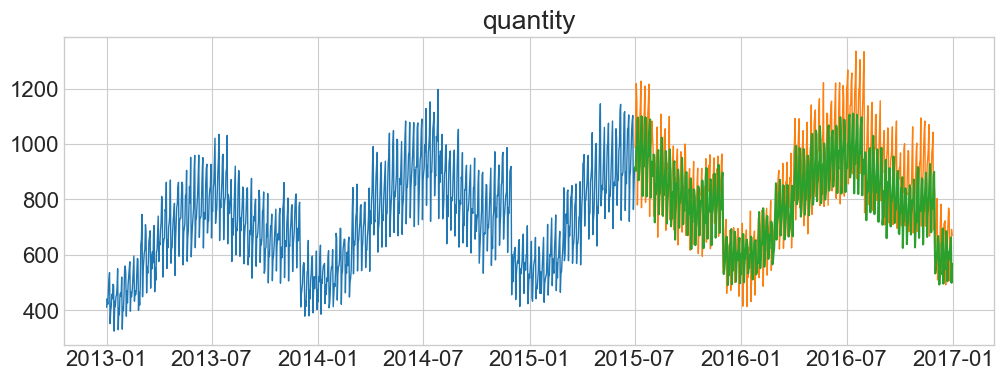

sales_total -- RMSE: 901


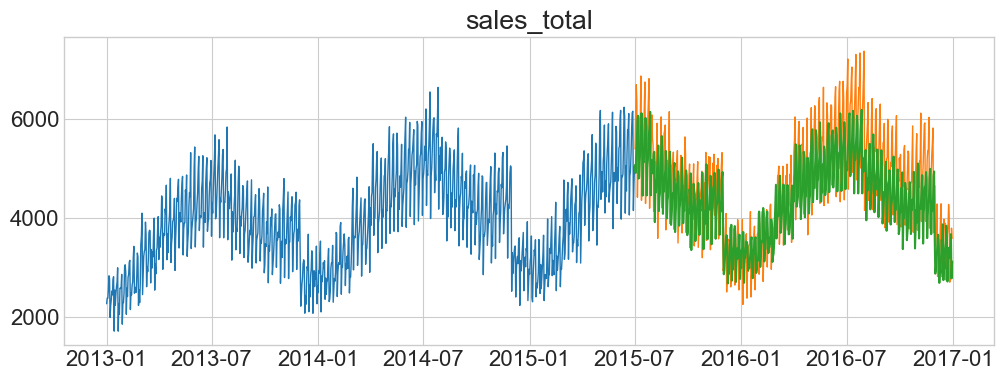

In [36]:
for col in train.columns:
    plot_and_eval(col)


In [37]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_seasonal', 
                            target_var = col)


In [38]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
18,holts_seasonal,quantity,161.0
14,104_day_moving_avg,quantity,185.0
16,holts_optimized,quantity,188.0
6,4_day_moving_avg,quantity,193.0
0,last_observed_value,quantity,195.0
12,52_day_moving_avg,quantity,200.0
8,12_day_moving_avg,quantity,210.0
4,30d moving average,quantity,211.0
10,26_day_moving_avg,quantity,212.0
2,simple_average,quantity,224.0


Our best implementation of Holt's Seasonal Trend is significantly outperforming all other models made thus far.

# Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day.

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence.

In the below example:
1. Compute the 365 average year over year differences from 2013 through 2015 2. Add that average delta to the values during 2015. 3. Set the index in your yhat dataframe to represent the dates those predictions are make for.

Let's get started....

# Re-split data

In [39]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']


# Make Predictions

In [40]:
# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015.
yhat_df = train['2015'] + train.diff(365).mean()

# set yhat_df to index of validate
yhat_df.index = validate.index


In [41]:
yhat_df.head()


,quantity,sales_total
sale_date,,
2016-01-01,582.346575,3221.962986
2016-01-02,617.346575,3488.262986
2016-01-03,651.346575,3592.892986
2016-01-04,715.346575,3993.672986
2016-01-05,512.346575,2748.762986


# Plot and Evaluate

quantity -- RMSE: 163


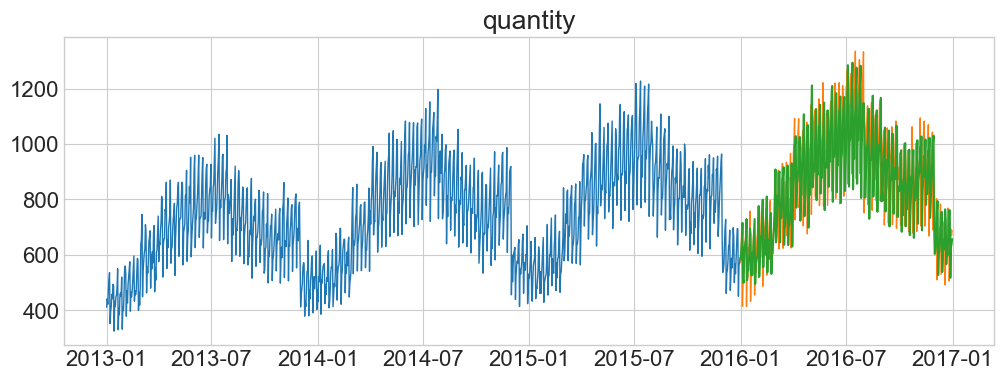

sales_total -- RMSE: 905


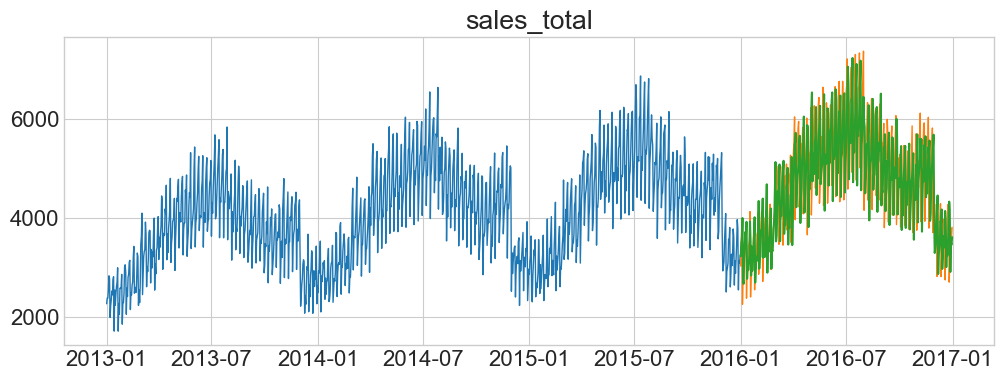

In [42]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = 'previous year', target_var = col)


Conclusion

Which model did the best?

In [43]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
18,holts_seasonal,quantity,161.0
20,previous year,quantity,163.0
14,104_day_moving_avg,quantity,185.0
16,holts_optimized,quantity,188.0
6,4_day_moving_avg,quantity,193.0
0,last_observed_value,quantity,195.0
12,52_day_moving_avg,quantity,200.0
8,12_day_moving_avg,quantity,210.0
4,30d moving average,quantity,211.0
10,26_day_moving_avg,quantity,212.0


In [44]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]


,model_type,target_var,rmse
18,holts_seasonal,quantity,161.0
19,holts_seasonal,sales_total,901.0


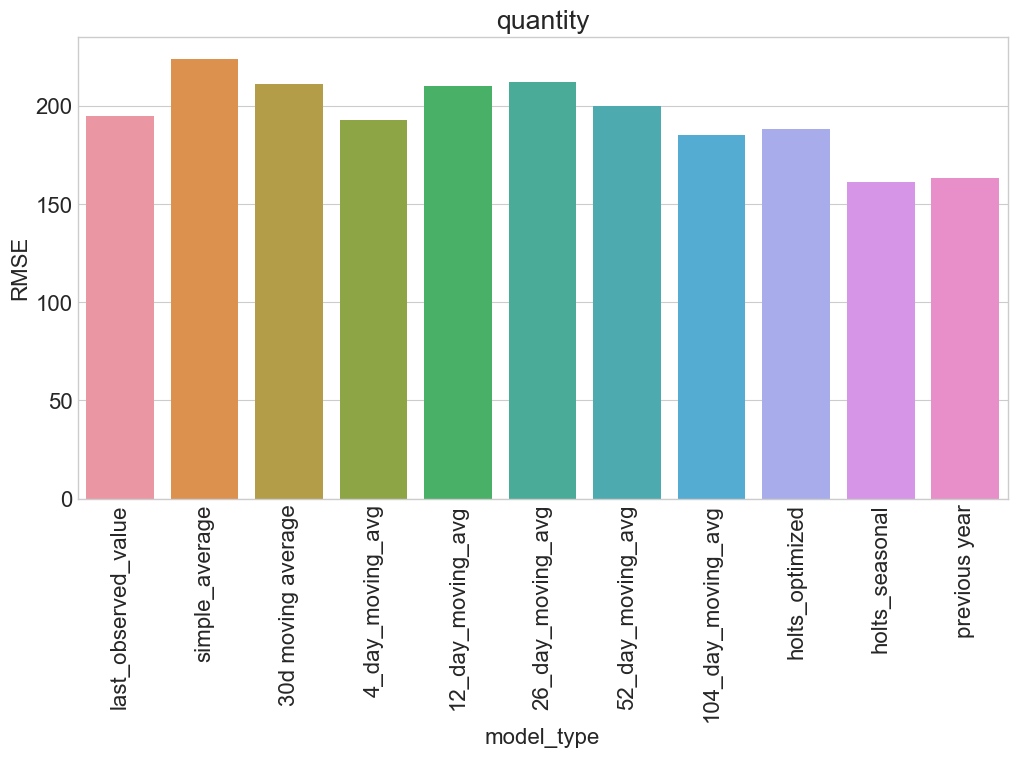

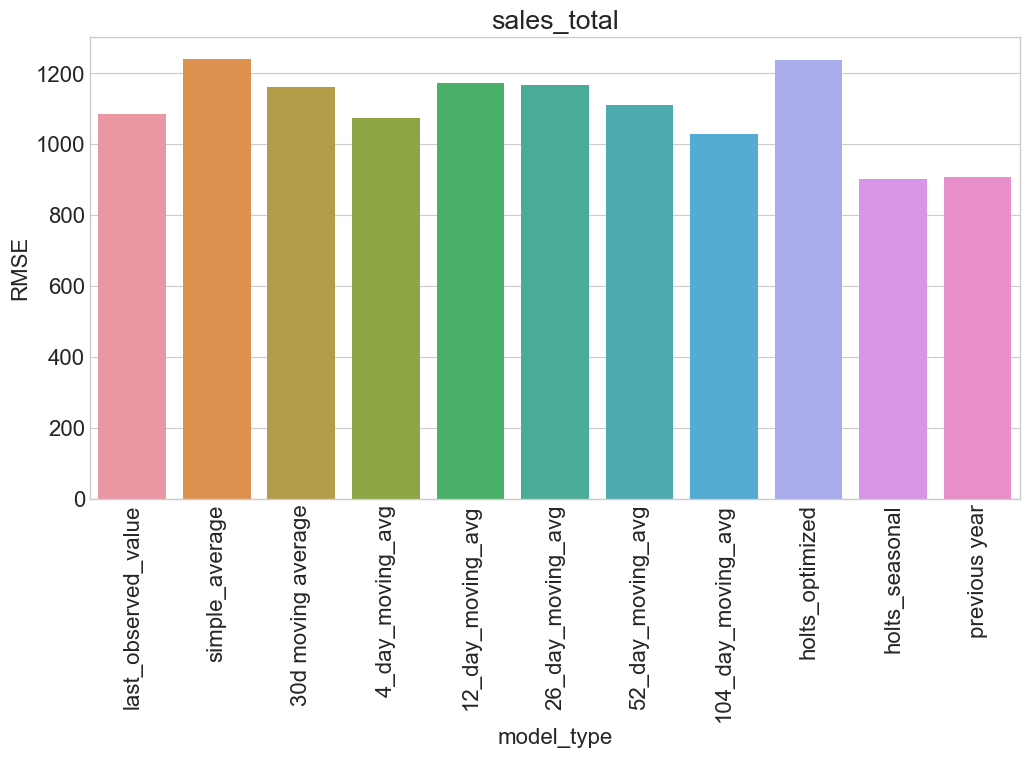

In [45]:
for col in train.columns:
    x = eval_df[eval_df.target_var == col]['model_type']
    y = eval_df[eval_df.target_var == col]['rmse']
    plt.figure(figsize=(12, 6))
    sns.barplot(x=x, y=y)
    plt.title(col)
    plt.ylabel('RMSE')
    plt.xticks(rotation=90)
    plt.show()


# Performance on Test

Now that we have identified our one best model for each target variable, we can evaluate its peformance on our test data. As a reminder, .forecast() allows us to make predictions, but the method always starts after the end of the training data. To get to the test data, we will need to increase the number of periods being predicted to be equal to the combined periods of validate and test.

We altered our train-validate-test split to perform the previous cycle approach. Let's reset to the original train-validate-test split.

In [46]:
train = df_resampled[:train_size]
validate = df_resampled[train_size:validate_end_index]
test = df_resampled[validate_end_index:]
train.shape, validate.shape, test.shape


((912, 2), (547, 2), (366, 2))

In [47]:
yhat_df = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + test.shape[0] + 1),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0] + 1)})
yhat_df


,sales_total,quantity
2015-07-02,5063.395195,916.067643
2015-07-03,4903.510511,902.986913
2015-07-04,5351.857222,987.038092
2015-07-05,5530.750733,995.696362
2015-07-06,5982.445591,1084.699520
...,...,...
2017-12-27,3397.685997,634.146824
2017-12-28,3667.164812,662.977307
2017-12-29,2772.462277,499.405162
2017-12-30,3115.664967,568.192566


The original test set started on 2016-12-31, so we can slice out that portion from our yhat_df:

In [48]:
yhat_df = yhat_df['2016-12-31':]


In [49]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='train')
    plt.plot(validate[target_var], color='#ff7f00', label='validate')
    plt.plot(test[target_var], color='#4daf4a',label='test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.legend()
    plt.title(target_var)
    plt.show()


FINAL PERFORMANCE OF MODEL ON TEST DATA
rmse-sales total:  1003.5022184569442
rmse-quantity:  179.09968780222354


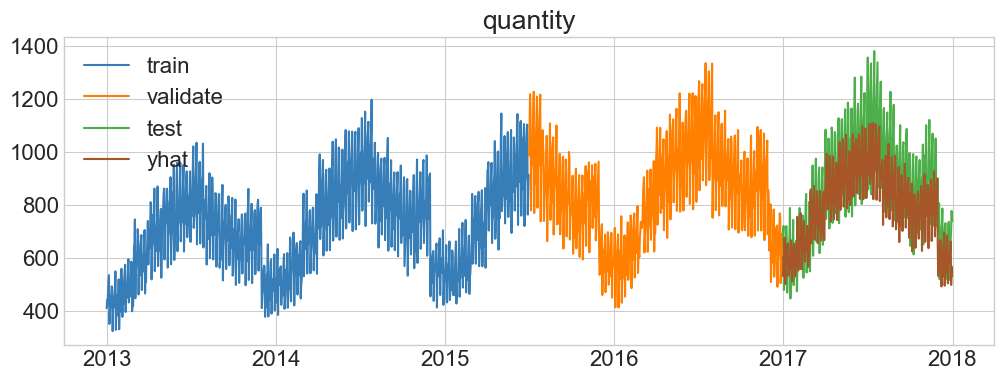

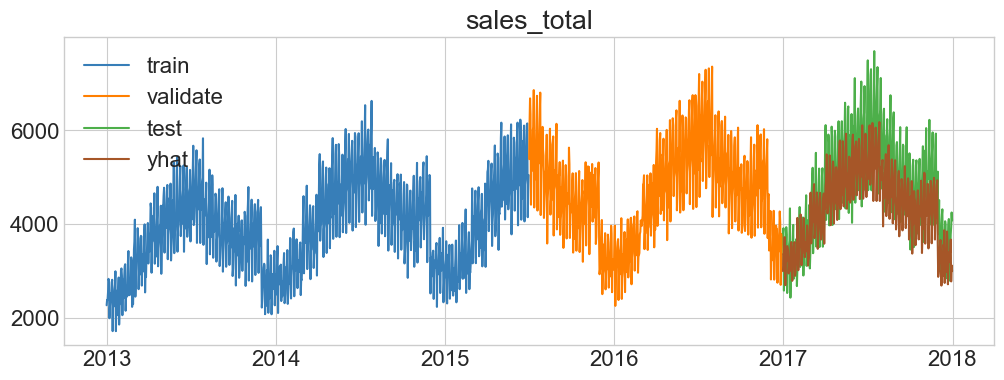

In [50]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

print('FINAL PERFORMANCE OF MODEL ON TEST DATA')
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)
for col in train.columns:
    final_plot(col)


Our RMSE of our final model did get noticably worse on the test data. Its possible that while the performance of the model starts high, it degrades the further out it projects. Let's take a look at what a projection into 2018 would look like.

# Forcasting Into Future

Predicting 2018 simply requires us to extend the value passed to .forecast() by an additional 365 periods and then slicing out what we want:

In [51]:
forecast = pd.DataFrame({'sales_total': hst_sales_fit3.forecast(validate.shape[0] + test.shape[0] + 1 + 365),
                           'quantity': hst_quantity_fit3.forecast(validate.shape[0] + test.shape[0] + 1 + 365)})
forecast = forecast['2018':]
forecast


,sales_total,quantity
2018-01-01,3363.334523,606.267448
2018-01-02,3349.775192,596.371893
2018-01-03,3716.973163,677.046567
2018-01-04,3716.196260,676.299413
2018-01-05,2693.419884,502.762289
...,...,...
2018-12-27,3397.691584,634.147980
2018-12-28,3667.170343,662.978451
2018-12-29,2772.467753,499.406295
2018-12-30,3115.670388,568.193687


In [52]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], color='#377eb8', label='Train')
    plt.plot(validate[target_var], color='#ff7f00', label='Validate')
    plt.plot(test[target_var], color='#4daf4a', label='Test')
    plt.plot(yhat_df[target_var], color='#a65628', label='yhat')
    plt.plot(forecast[target_var], color='#984ea3', label='Forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()


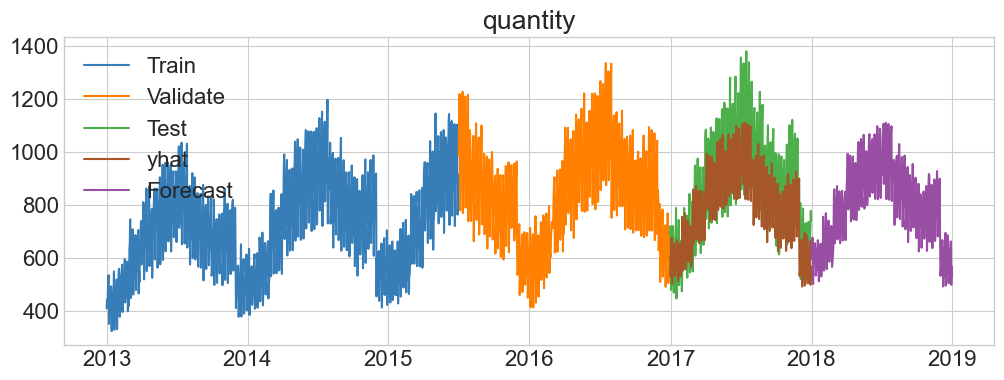

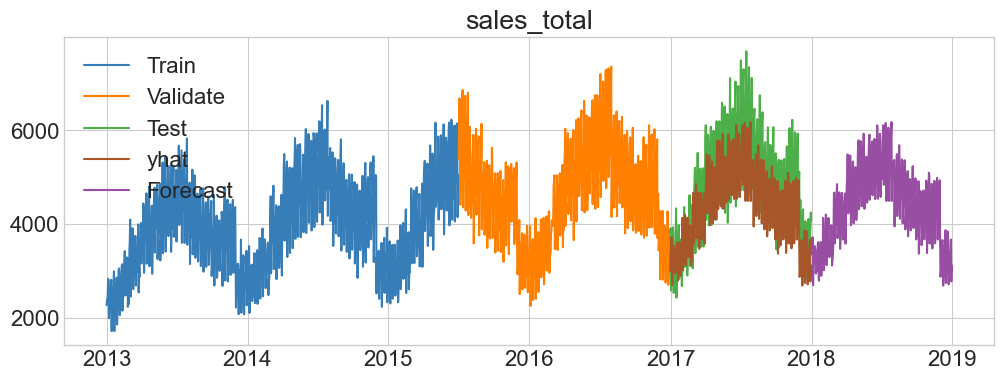

In [53]:
for col in train.columns:
    final_plot(col)


This data set was made of synthetic data with a clear and observable pattern. It allows us to observe the risk of long term performance degredation. While Holt's Seasonal Trend outperformed Previous Cycle on validate, Previous Cycle would have probably been the best model to use. Holt's Seasonal Trend is failing to demonstrate the higher maximum value in each subsequent cycle.

However, I can be confident in this claim because I have atypical knowledge that this data is extremely predictable. Real data is rarely as reliable, and conclusions are rarely as clear as the example we have shown here.

Forecasting is an art as much as it is a science, as the environment that created the values of our historical data may be very different from the environment that creates future values.

"It's tough to make predictions, especially about the future." - Yogi Berra

# Exercises

The end result of this exercise should be a Jupyter notebook named model.

Using saas.csv or log data from API usage

Split data (train/test) and resample by any period, except daily, and aggregate using the sum.
Forecast, plot and evaluate using each at least 4 of the methods we discussed:
Last Observed Value
Simple Average
Moving Average
Holt's Linear Trend
Holt's Seasonal Trend
Based on previous year/month/etc., this is up to you.

In [54]:
df = pd.read_csv('/Users/deadrienhill/Downloads/saas.csv')
df.to_csv('saas.csv')

In [55]:
df.head()

,Month_Invoiced,Customer_Id,Invoice_Id,Subscription_Type,Amount
0,2014-01-31,1000000,5000000,0.0,0.0
1,2014-01-31,1000001,5000001,2.0,10.0
2,2014-01-31,1000002,5000002,0.0,0.0
3,2014-01-31,1000003,5000003,0.0,0.0
4,2014-01-31,1000004,5000004,1.0,5.0


In [56]:
df.isna().sum()

Month_Invoiced       0
Customer_Id          0
Invoice_Id           0
Subscription_Type    0
Amount               0
dtype: int64

In [57]:
df.columns = df.columns.str.lower()
df.month_invoiced = pd.to_datetime(df.month_invoiced)
df = df.set_index('month_invoiced').sort_index()

In [58]:
df

,customer_id,invoice_id,subscription_type,amount
month_invoiced,,,,
2014-01-31,1000000,5000000,0.0,0.0
2014-01-31,1000001,5000001,2.0,10.0
2014-01-31,1000002,5000002,0.0,0.0
2014-01-31,1000003,5000003,0.0,0.0
2014-01-31,1000004,5000004,1.0,5.0
...,...,...,...,...
2017-12-31,1029395,5790453,0.0,0.0
2017-12-31,1029396,5790454,0.0,0.0
2017-12-31,1029397,5790455,3.0,15.0


In [59]:
df_resampled = df.resample('d')[['subscription_type','amount']].sum()
df_resampled.head()


,subscription_type,amount
month_invoiced,,
2014-01-31,7170.0,35850.0
2014-02-01,0.0,0.0
2014-02-02,0.0,0.0
2014-02-03,0.0,0.0
2014-02-04,0.0,0.0


In [60]:
train_size = int(len(df_resampled) * .5)
validate_size = int(len(df_resampled) * .3)
test_size = int(len(df_resampled) - train_size - validate_size)
validate_end_index = train_size + validate_size

# split into train, validation, test
train = df_resampled[: train_size]
validate = df_resampled[train_size : validate_end_index]
test = df_resampled[validate_end_index : ]


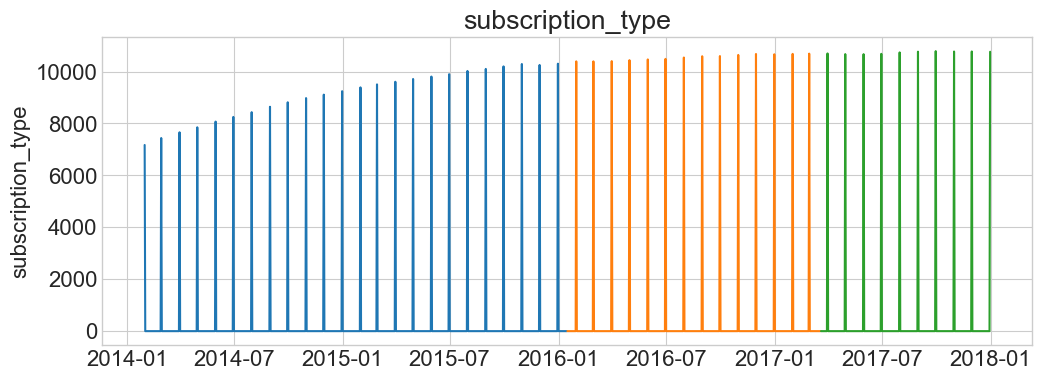

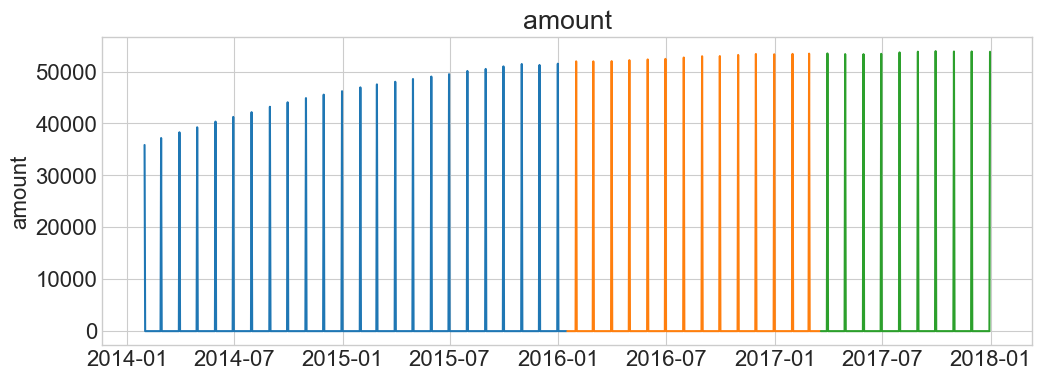

In [61]:
for col in train.columns:
    plt.figure(figsize=(12,4))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()


In [62]:
# evaluation function to compute rmse
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse


In [63]:
# plot and evaluate 
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label = 'Train', linewidth = 1)
    plt.plot(validate[target_var], label = 'Validate', linewidth = 1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()


In [64]:
# Create the empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df


,model_type,target_var,rmse


In [65]:
# function to store rmse for comparison purposes
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var], 'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)


In [70]:
# take the last item of sales total and assign to variable
last_subscription = train['subscription_type'][-1:][0]

# take the last item of quantity and assign to variable
last_amount = train['amount'][-1:][0]

yhat_df = pd.DataFrame(
    {'subscription_type': [last_subscription],
     'amount': [last_amount]},
    index=validate.index)

yhat_df.head()


,subscription_type,amount
month_invoiced,,
2016-01-16,0.0,0.0
2016-01-17,0.0,0.0
2016-01-18,0.0,0.0
2016-01-19,0.0,0.0
2016-01-20,0.0,0.0


subscription_type -- RMSE: 1905


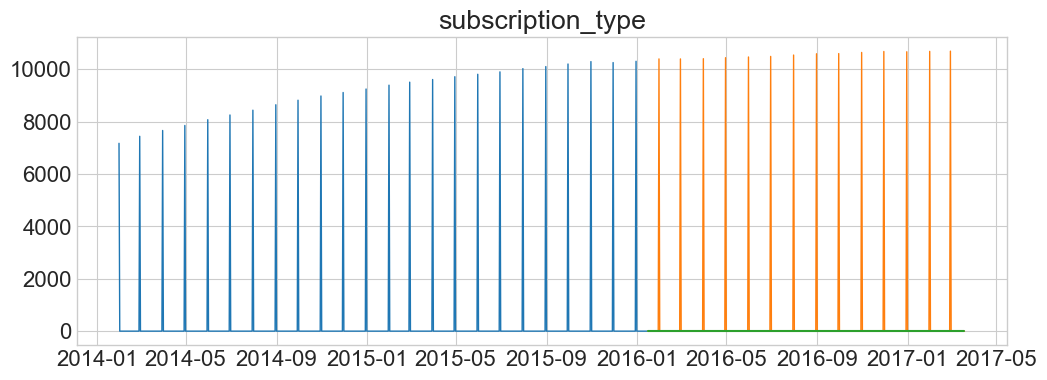

amount -- RMSE: 9526


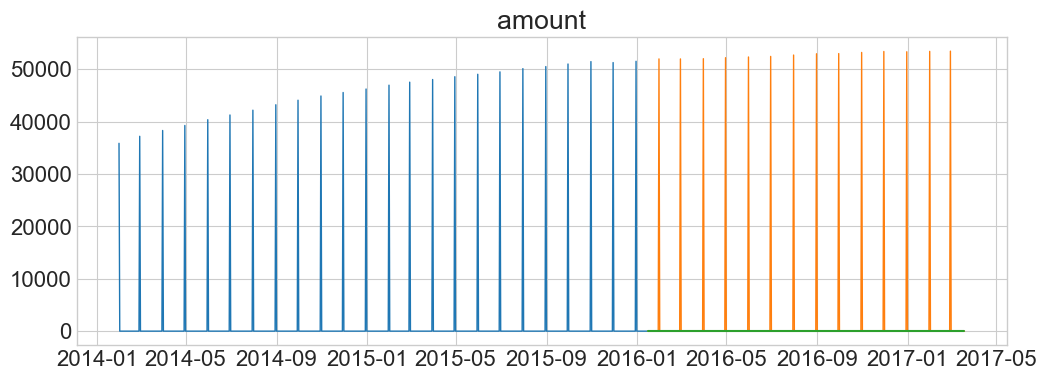

In [71]:
for col in train.columns:
    plot_and_eval(col)


In [72]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)


In [73]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,subscription_type,1905.0
1,last_observed_value,amount,9526.0


In [76]:
# compute simple average of sales_total (from train data)
avg_subscription = round(train['subscription_type'].mean(), 2)

# compute simple average of quantity (from train data)
avg_amount = round(train['amount'].mean(), 2)


yhat_df = pd.DataFrame({'subscription_type': [avg_subscription],
                        'amount': [avg_amount]},
                        index=validate.index)

yhat_df.head(3)


,subscription_type,amount
month_invoiced,,
2016-01-16,305.91,1529.57
2016-01-17,305.91,1529.57
2016-01-18,305.91,1529.57


subscription_type -- RMSE: 1874


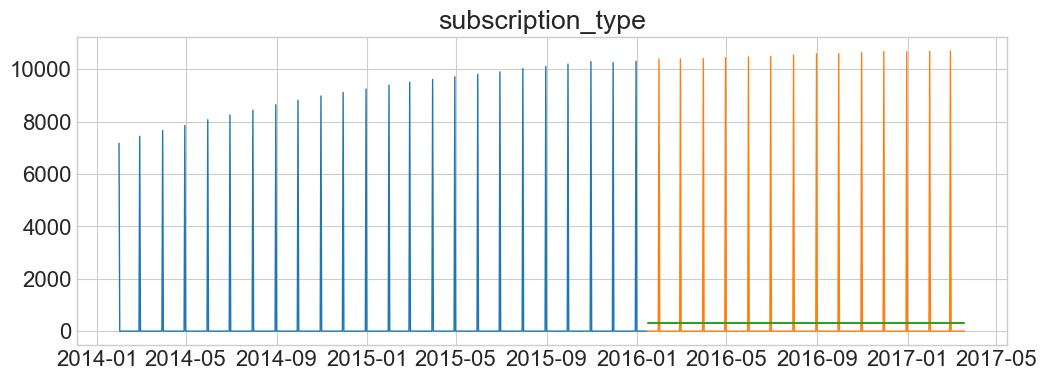

amount -- RMSE: 9371


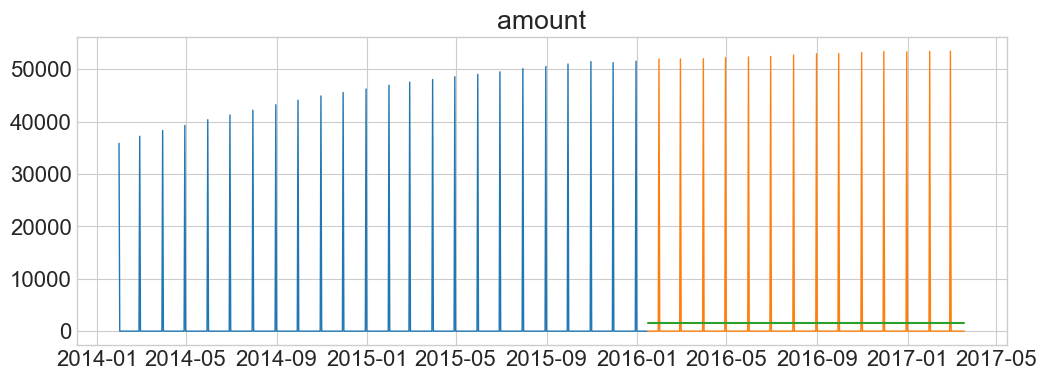

In [77]:
for col in train.columns:
    plot_and_eval(col)


In [78]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,subscription_type,1905.0
1,last_observed_value,amount,9526.0
2,simple_average,subscription_type,1874.0
3,simple_average,amount,9371.0


In [79]:
# compute a 30 day rolling average, 
# use the most recent/last 30 day period value to predict forward. 

period = 30

rolling_sales = round(train['subscription_type'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['amount'].rolling(period).mean()[-1], 2)

# yhat_df = make_predictions()

yhat_df = pd.DataFrame({'subscription_type': rolling_sales,
                        'amount': rolling_quantity},
                         index=validate.index)
yhat_df.head()


,subscription_type,amount
month_invoiced,,
2016-01-16,343.37,1716.83
2016-01-17,343.37,1716.83
2016-01-18,343.37,1716.83
2016-01-19,343.37,1716.83
2016-01-20,343.37,1716.83


subscription_type -- RMSE: 1874


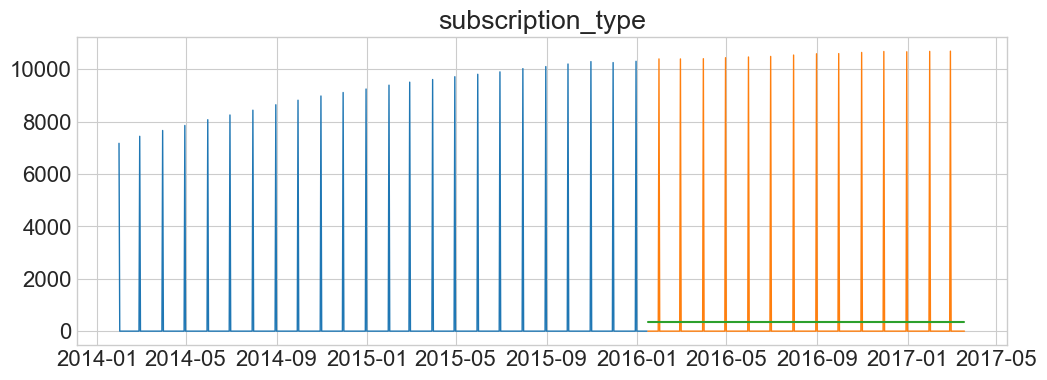

amount -- RMSE: 9369


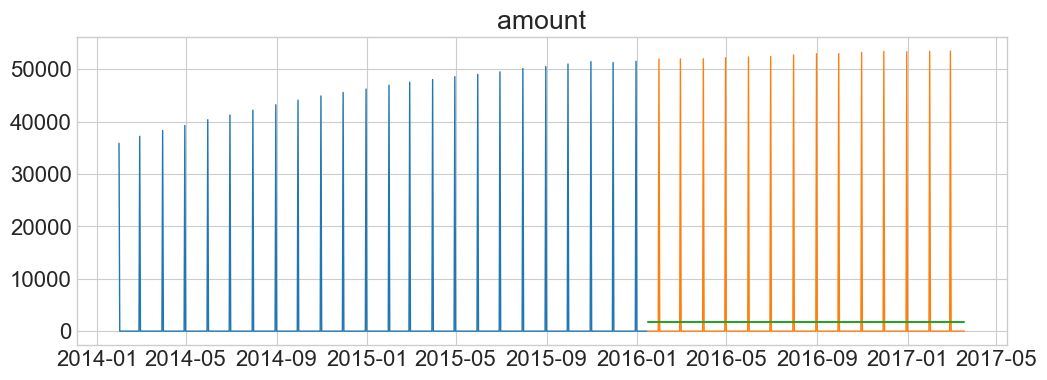

In [80]:
for col in train.columns:
    plot_and_eval(col)


In [81]:
for col in train.columns:
    eval_df = append_eval_df(model_type='30d moving average', 
                             target_var = col)
eval_df


,model_type,target_var,rmse
0,last_observed_value,subscription_type,1905.0
1,last_observed_value,amount,9526.0
2,simple_average,subscription_type,1874.0
3,simple_average,amount,9371.0
4,30d moving average,subscription_type,1874.0
5,30d moving average,amount,9369.0


In [83]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['subscription_type'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['amount'].rolling(p).mean()[-1], 2)
    yhat_df = pd.DataFrame({'subscription_type': rolling_sales,
                            'amount': rolling_quantity},
                            index=validate.index)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)


In [84]:
# get the min rmse for each variable

min_rmse_sales_total = eval_df.groupby('target_var')['rmse'].min()[0]
min_rmse_quantity = eval_df.groupby('target_var')['rmse'].min()[1]

# filter only the rows that match those rmse to find out 
# which models are best thus far
eval_df[((eval_df.rmse == min_rmse_sales_total) | 
         (eval_df.rmse == min_rmse_quantity)
        )]


,model_type,target_var,rmse
2,simple_average,subscription_type,1874.0
4,30d moving average,subscription_type,1874.0
5,30d moving average,amount,9369.0
14,104_day_moving_avg,subscription_type,1874.0


As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.

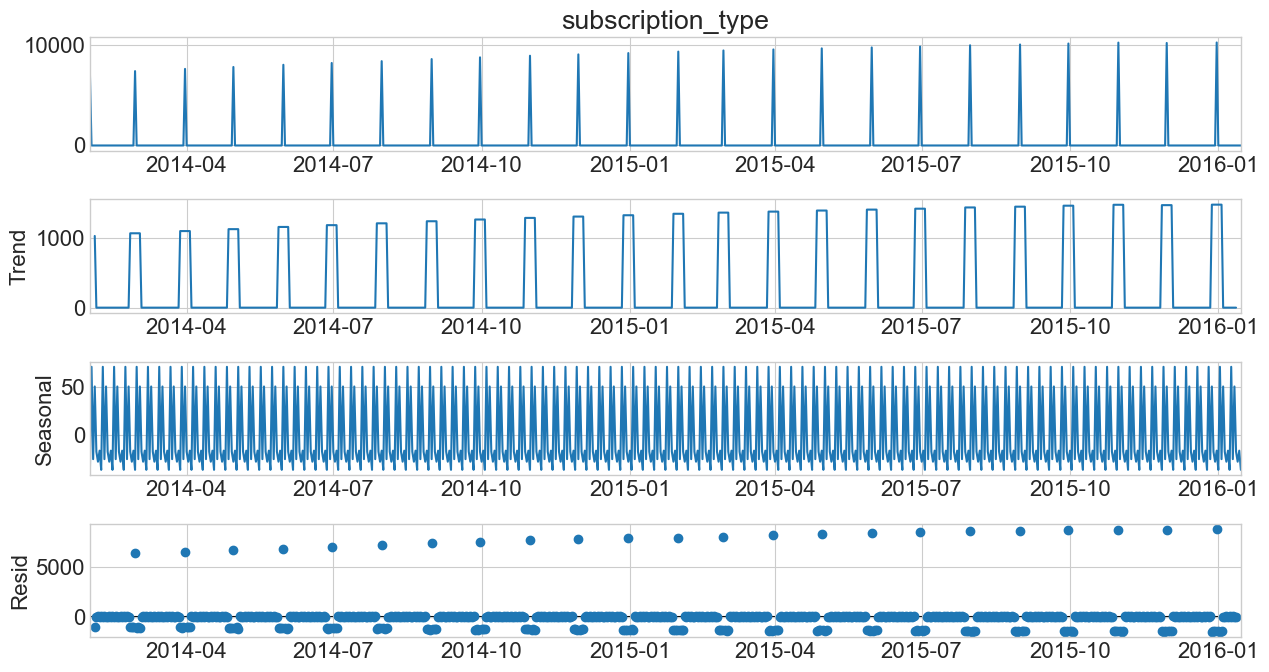

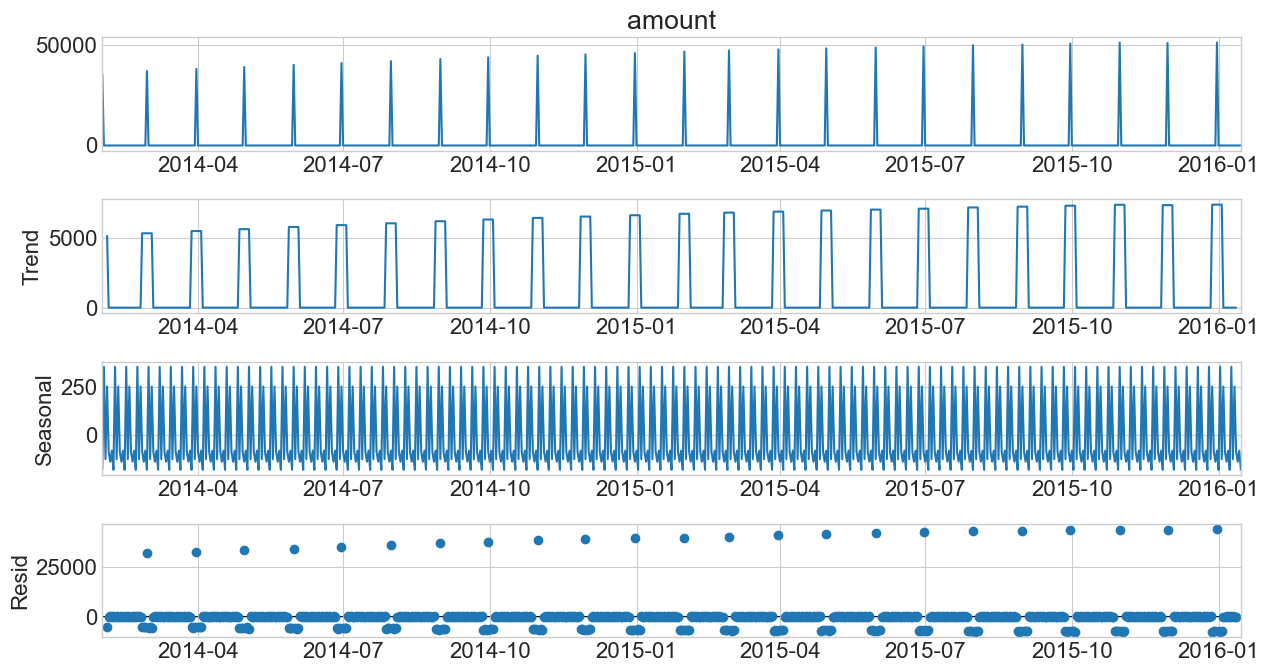

In [86]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('D').mean()).plot()


In [87]:
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)


In [88]:
yhat_df.head()


,subscription_type,amount
month_invoiced,,
2016-01-16,-18.39,-91.95
2016-01-17,-1.07,-5.36
2016-01-18,16.07,80.36
2016-01-19,33.04,165.22
2016-01-20,49.85,249.23


subscription_type -- RMSE: 2155


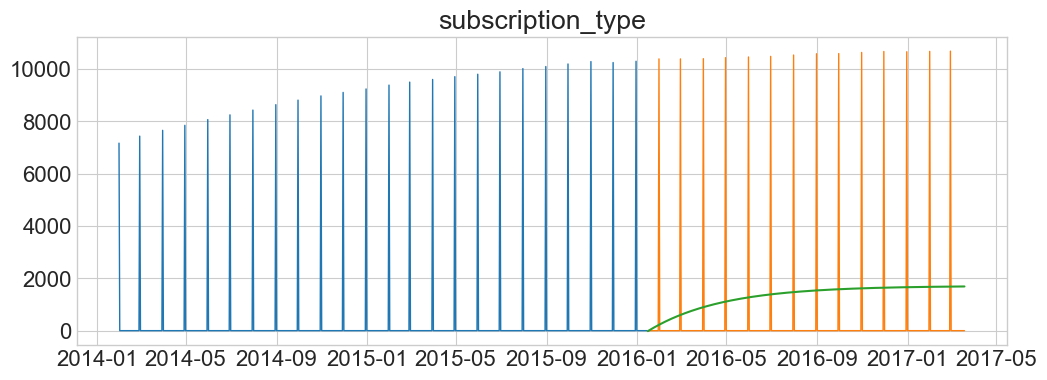

amount -- RMSE: 10777


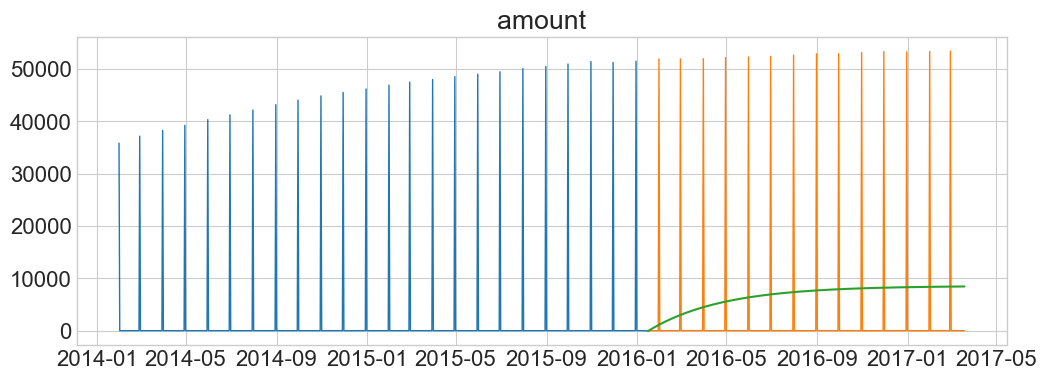

In [89]:
for col in train.columns:
    plot_and_eval(target_var = col)


In [90]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)


In [91]:
eval_df.sort_values(by='rmse')


,model_type,target_var,rmse
14,104_day_moving_avg,subscription_type,1874.0
2,simple_average,subscription_type,1874.0
4,30d moving average,subscription_type,1874.0
12,52_day_moving_avg,subscription_type,1875.0
10,26_day_moving_avg,subscription_type,1875.0
0,last_observed_value,subscription_type,1905.0
8,12_day_moving_avg,subscription_type,1905.0
6,4_day_moving_avg,subscription_type,1905.0
16,holts_optimized,subscription_type,2155.0
5,30d moving average,amount,9369.0
